In [7]:
import os, glob
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

import pandas as pd

from astropy.nddata import CCDData
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Tophat2DKernel as Kernel

import ccdproc

from util import *

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}


# Extract the Signal

Done reading in data, starting to clean the chip gap...
Working on Harris-R


Working on Harris-B


Working on Harris-V


Working on Bessell-U


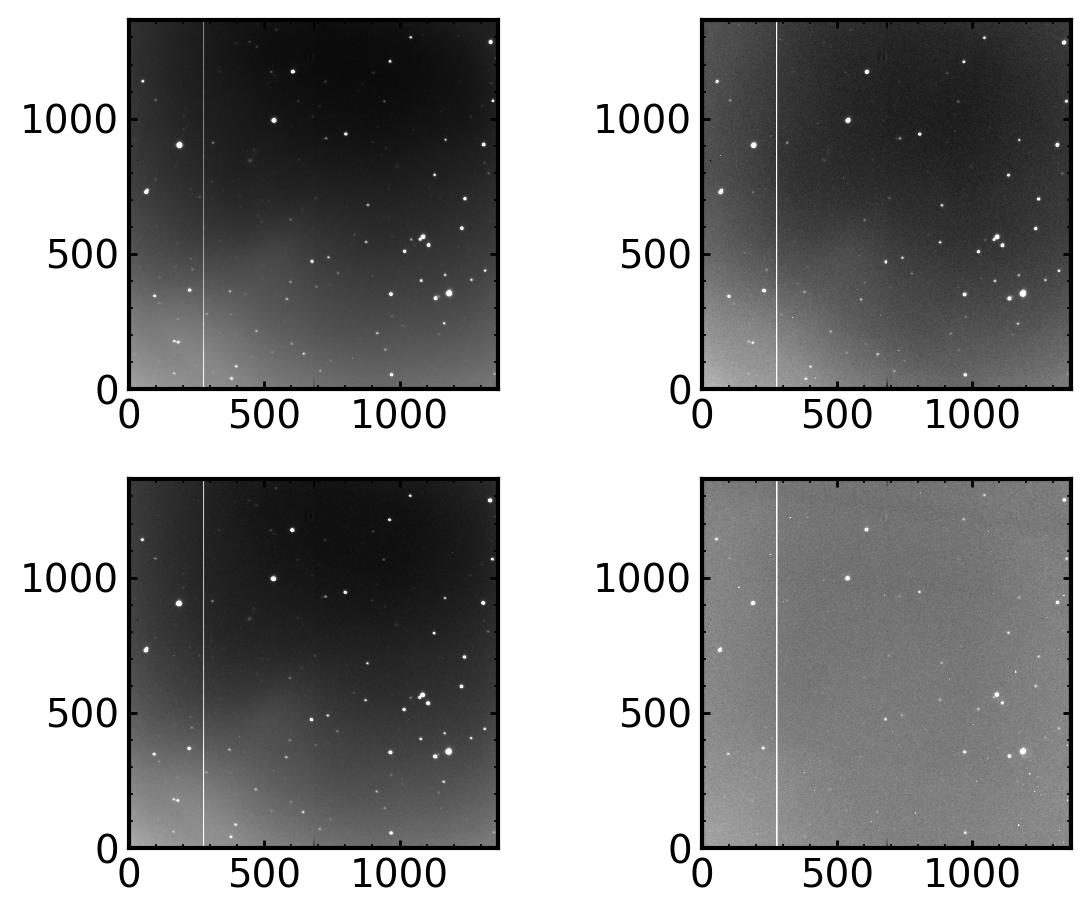

In [42]:
data_path = os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "calib")
overwrite = True

if overwrite:
    wcs_data_path = os.path.join(data_path, "*WCS*")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]

    print("Done reading in data, starting to clean the chip gap...")

    fig = plt.figure()
    for ii, d in enumerate(wcs_data):

        print(f'Working on {d.meta["FILTER"]}')
        # smooth over the chip gap because it's annoying
        kernel = Kernel(50)
        wcs_data[ii].data = interpolate_replace_nans(d.data, kernel)

        # plot all the images to make sure the chip gap looks okay
        img = wcs_data[ii]
        wcs = img.wcs
        ax = fig.add_subplot(2,2,ii+1) 

        ax.imshow(
            img.data,
            origin="lower",
            norm=simple_norm(
                data=img.data,
                stretch="linear",
                **norm_kwargs[img.meta["FILTER"]]
            ),
            cmap="gray"
        )

        wcs_data[ii].write(wcs_data_files[ii].replace(".fits", ".NOCHIPGAP.fits"))
        
else:
    # we can just read in the ones previously computed, cause this takes a while
    wcs_data_path = os.path.join(data_path, "*WCS.NOCHIPGAP.fits")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]


In [43]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)
apertures = [aperture.to_pixel(d.wcs) for d in wcs_data]
kuiper = Kuiper(apertures[0].r)
res = {v[0].meta["FILTER"]: aperture_photometry(*v) for v in zip(wcs_data, apertures)}

res

{'Harris-R': <QTable length=1>
   id       xcenter          ycenter         aperture_sum  
              pix              pix               adu       
 int64      float64          float64           float64     
 ----- ----------------- ---------------- -----------------
     1 689.1902316237959 705.135713586497 554664.7078300073,
 'Harris-B': <QTable length=1>
   id       xcenter           ycenter         aperture_sum   
              pix               pix               adu        
 int64      float64           float64           float64      
 ----- ----------------- ----------------- ------------------
     1 692.4297288520879 704.3353420770002 352200.82818560355,
 'Harris-V': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 686.6747350069558 707.9193545467556 524919.9

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


Text(0.5, 0.01, 'Right Ascension')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


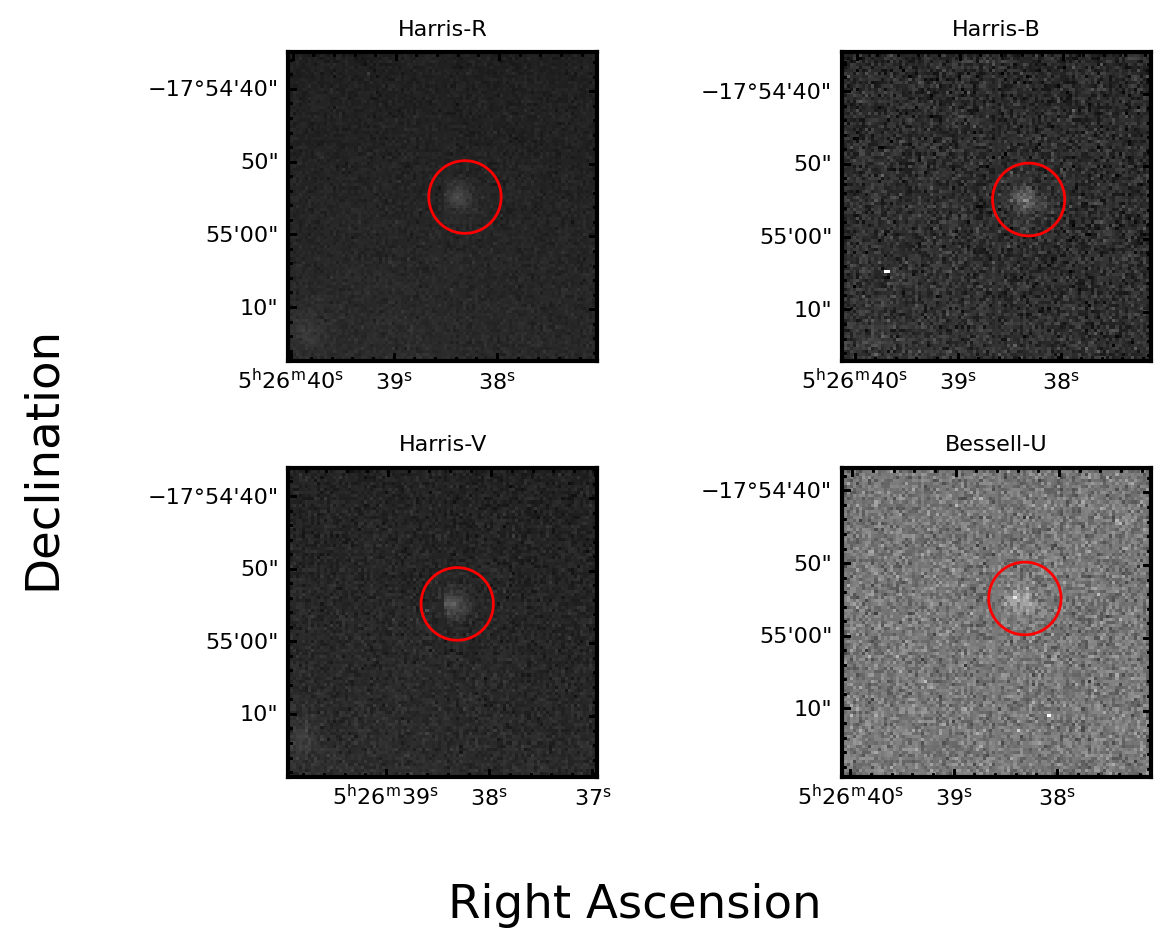

In [44]:
fs = 8
ms = 500
fig = plt.figure()

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    aper = a.to_sky(wcs)
    print(aper.positions)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    # ax.scatter_coord(pos, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    dx = dy = 50
    midx = img.data.shape[0]//2
    midy = img.data.shape[0]//2 + 20
    xlim = (midx-dx, midx+dx)
    ylim = (midy-dy, midy+dy)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

In [45]:
res_to_stack = []
for k, row in res.items():
    row["FILTER"] = k
    row["aperture_sum_e"] = row["aperture_sum"] * Kuiper.gain
    row["aperture_sum_photons"] = row["aperture_sum_e"] * Kuiper.electron_to_photons
    
    res_to_stack.append(row)
    
data = vstack(res_to_stack).to_pandas()
data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons
0,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,1.719461e+06
1,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.091823e+06
2,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,1.627252e+06
3,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,2.948306e+05


# Sky Background Noise

Put a bunch of apertures on the background of the images and median them

In [46]:
from astropy.stats import SigmaClip
from photutils.background import LocalBackground, SExtractorBackground

all_bckgd = dict(
    FILTER = [],
    bckgd_adu = [],
    bckgd_err_adu = []
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)

for img in wcs_data:
    bkg = LocalBackground(
        inner_radius=kuiper.aperture_radius,
        outer_radius=2*kuiper.aperture_radius,
        bkg_estimator=SExtractorBackground(SigmaClip(sigma=3))
    )

    aper = aperture.to_pixel(img.wcs)

    bkg_res = bkg(img.data, *aper.positions)*kuiper.npix
    
    all_bckgd["FILTER"].append(img.header["FILTER"])
    all_bckgd["bckgd_adu"].append(bkg_res)
    all_bckgd["bckgd_err_adu"].append(np.sqrt(bkg_res))

bckgd_df = pd.DataFrame(all_bckgd)
bckgd_df["bckgd_e"] = bckgd_df.bckgd_adu*Kuiper.gain
bckgd_df["bckgd_err_e"] = bckgd_df.bckgd_err_adu*Kuiper.gain
bckgd_df["bckgd_photons"] = bckgd_df.bckgd_e*Kuiper.electron_to_photons
bckgd_df["bckgd_err_photons"] = bckgd_df.bckgd_err_e*Kuiper.electron_to_photons

data = pd.merge(data, bckgd_df, on="FILTER")

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons
0,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,1.719461e+06,549467.648932,741.260851,1.703350e+06,2297.908637,1.703350e+06,2297.908637
1,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.091823e+06,349059.933154,590.812943,1.082086e+06,1831.520122,1.082086e+06,1831.520122
2,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,1.627252e+06,521899.427660,722.426071,1.617888e+06,2239.520819,1.617888e+06,2239.520819
3,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,2.948306e+05,94426.309579,307.288642,2.927216e+05,952.594791,2.927216e+05,952.594791


# Background Subtraction

Now, we need to subtract the background from the signal (ie. the aperture sum) in both e and photons. This is so we can get a SNR estimate from the electrons aperture sum and then, finally, convert the aperture sum in photons to usable units.

In [47]:
data["signal_e"] = data.aperture_sum_e - data.bckgd_e
data["signal_photons"] = data.aperture_sum_photons - data.bckgd_photons

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons
0,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,1.719461e+06,549467.648932,741.260851,1.703350e+06,2297.908637,1.703350e+06,2297.908637,16110.882584,16110.882584
1,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.091823e+06,349059.933154,590.812943,1.082086e+06,1831.520122,1.082086e+06,1831.520122,9736.774597,9736.774597
2,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,1.627252e+06,521899.427660,722.426071,1.617888e+06,2239.520819,1.617888e+06,2239.520819,9363.468785,9363.468785
3,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,2.948306e+05,94426.309579,307.288642,2.927216e+05,952.594791,2.927216e+05,952.594791,2109.043030,2109.043030


# Dark Noise

Estimate the dark noise by reading in the darks and then summing all of the values in them

In [48]:
dark_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_DARKS_FIFTY.fits")
)

dark_noise_adu = np.nanstd(dark_combined.data)

data["dark_noise_adu"] = dark_noise_adu
data["dark_noise_e"] = Kuiper.gain*dark_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons,dark_noise_adu,dark_noise_e
0,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,1.719461e+06,549467.648932,741.260851,1.703350e+06,2297.908637,1.703350e+06,2297.908637,16110.882584,16110.882584,22.669084,70.274159
1,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.091823e+06,349059.933154,590.812943,1.082086e+06,1831.520122,1.082086e+06,1831.520122,9736.774597,9736.774597,22.669084,70.274159
2,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,1.627252e+06,521899.427660,722.426071,1.617888e+06,2239.520819,1.617888e+06,2239.520819,9363.468785,9363.468785,22.669084,70.274159
3,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,2.948306e+05,94426.309579,307.288642,2.927216e+05,952.594791,2.927216e+05,952.594791,2109.043030,2109.043030,22.669084,70.274159


# Read Noise

Estimate the read noise from the bias images

In [49]:
bias_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_BIAS.fits")
)

files = ReductionFiles(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data"))
files.read_and_organize("AT2024wsd")
bias_data = [CustomCCDData.read(bias_file) for bias_file in files.bias_files["none"]]

rn = []
for _ in range(100):
    rng_choice = np.random.choice(len(bias_data))
    read_noise = ccdproc.subtract_bias(bias_combined, bias_data[rng_choice])    
    rn.append(read_noise)
    
read_noise_adu = np.nanstd(rn)

data["read_noise_adu"] = read_noise_adu
data["read_noise_e"] = Kuiper.gain * read_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e
0,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,1.719461e+06,549467.648932,741.260851,1.703350e+06,2297.908637,1.703350e+06,2297.908637,16110.882584,16110.882584,22.669084,70.274159,3.16382,9.807841
1,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.091823e+06,349059.933154,590.812943,1.082086e+06,1831.520122,1.082086e+06,1831.520122,9736.774597,9736.774597,22.669084,70.274159,3.16382,9.807841
2,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,1.627252e+06,521899.427660,722.426071,1.617888e+06,2239.520819,1.617888e+06,2239.520819,9363.468785,9363.468785,22.669084,70.274159,3.16382,9.807841
3,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,2.948306e+05,94426.309579,307.288642,2.927216e+05,952.594791,2.927216e+05,952.594791,2109.043030,2109.043030,22.669084,70.274159,3.16382,9.807841


# Computing the Signal to Noise Ratio

In [50]:
data.signal_e / data.bckgd_err_e

0    7.011107
1    5.316226
2    4.181014
3    2.213998
dtype: float64

In [51]:
signal = data.signal_e
noise = np.sqrt(data.signal_e + kuiper.npix*(data.read_noise_e**2 + data.dark_noise_e**2 + data.bckgd_err_e**2))

print(signal/noise)

0    0.336083
1    0.254768
2    0.200415
3    0.105887
dtype: float64
